# CellMap for hippocampus cell data

The tutorial for hippocampus cell data ([La Manno et al. (2018)](https://doi.org/10.1038/s41586-018-0414-6)).


[RECODE](https://github.com/yusuke-imoto-lab/RECODE) is used for the noise reduction.

## Regular procedure

In [1]:
import cellmap
import anndata
import matplotlib.pyplot as plt
import numpy as np
import scanpy

The dataset is installed using the [scvelo](https://scvelo.readthedocs.io/en/stable/) package. 

In [2]:
import scvelo as scv
adata = scv.datasets.dentategyrus_lamanno()
adata

AnnData object with n_obs × n_vars = 18213 × 27998
    obs: 'Age', 'clusters'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'clusters_colors'
    obsm: 'X_tsne'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

Noise reduction by [RECODE](https://github.com/yusuke-imoto-lab/RECODE).

/home/yusukeimoto/.local/lib/python3.10/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/yusukeimoto/.local/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


start RECODE for scRNA-seq
end RECODE for scRNA-seq
log: {'seq_target': 'RNA', '#significant genes': 12242, '#non-significant genes': 7644, '#silent genes': 8112, 'ell': 137, 'Elapsed time': '0h 4m 5s 577ms'}


/home/yusukeimoto/.local/lib/python3.10/site-packages/screcode/screcode.py:678: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  dens = scipy.stats.kde.gaussian_kde(np.log10(norm_var[norm_var>0]))(x)


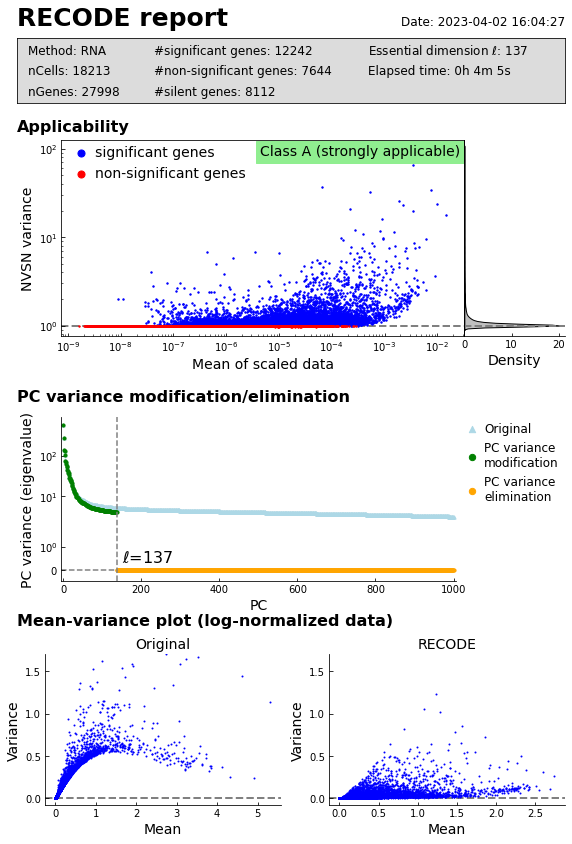

In [3]:
import screcode
recode = screcode.RECODE()
adata.layers['RECODE'] = recode.fit_transform(adata.X.toarray())
adata.layers['RECODE_log'] = scanpy.pp.log1p(adata.layers['RECODE'])
recode.report()

In [4]:
adata.layers['spliced'] = recode.transform(adata.layers['spliced'])
adata.layers['unspliced'] = recode.transform(adata.layers['unspliced'])

In [5]:
scanpy.pp.normalize_total(adata, target_sum=1e4,layer='RECODE')
scanpy.pp.log1p(adata,layer='RECODE')

Compute velocity by scVelo (stochastic mode) and show the stream on UMAP. 

In [ ]:
scv.pp.filter_and_normalize(adata)
scv.pp.moments(adata)
scv.tl.velocity(adata,mode='stochastic')
scv.tl.velocity_graph(adata)

Normalized count data: X.
computing neighbors


2023-04-02 16:08:50.171479: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-02 16:08:50.185622: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-02 16:08:50.340703: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-02 16:08:50.341619: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 16:08:52.893964: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

    finished (0:01:25) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:04:39) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:04:09) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/8 cores)


  0%|          | 0/18213 [00:00<?, ?cells/s]

In [ ]:
scv.pl.velocity_embedding_stream(adata)

In [ ]:
%%time
import cellmap

cellmap.Hodge_decomposition(adata, exp_2d_key='X_tsne', vel_2d_key='velocity_tsne', alpha=0.1)

In [ ]:
cellmap.view(adata, basis='X_tsne', show_graph = True, cluster_key='clusters')

In [ ]:
cellmap.view_cluster(adata, basis='X_tsne', show_graph=True, cluster_key='clusters', s=50)

In [ ]:
cellmap.view_surface(adata, basis='X_tsne', cluster_key ='clusters')

In [ ]:
cellmap.view_surface_3D(adata, basis='X_tsne', cluster_key ='clusters', elev=50, azim=65)

In [ ]:
cellmap.view_surface_3D_cluster(adata, basis='X_tsne', cluster_key ='clusters',elev=50,azim=65,s=30);

### Write expression and potential data as CSV file for **[CellMap viewer](https://github.com/yusuke-imoto-lab/CellMapViewer)**. 

In [ ]:
cellmap.write(adata, basis='X_tsne', filename='CellMap_tutorial_hippocampus',genes=['Aqp4','Aldoc','Cdk1','Mki67','Eomes','Neurod2'],expression_key='RECODE_log',use_HVG=False)

## Changing parameter $\alpha$

The parameter $\alpha$ adjust the rate of original/reduced dimensional information of gene expression and velocity. 

$\alpha=0$ uses only two-dimensional inormation; in contrast, $\alpha=1$ uses the original (non-dimensionaly reduction) information. 

In [ ]:
alpha_set = [0,0.5,1]
for alpha in alpha_set:
    cellmap.Hodge_decomposition(adata, exp_2d_key='X_tsne', vel_2d_key='velocity_tsne',potential_key='Hodge_potential_%0.1f' % alpha,alpha=alpha)
adata

In [ ]:
for alpha in alpha_set:
    cellmap.view(adata, basis='X_tsne', show_graph = True, potential_key='Hodge_potential_%0.1f' % alpha,cluster_key='clusters',title='alpha=%0.1f' % alpha,s=1)

In [ ]:
for alpha in alpha_set:
    cellmap.view_surface_3D(adata, basis='X_tsne', cluster_key ='clusters',potential_key='Hodge_potential_%0.1f' % alpha,elev=50,azim=65,title='alpha=%0.1f' % alpha)